# Taller (ejemplos-ejercicios) de Machine learning

En este taller se estudia la técnica de aprendizaje de máquina enfocada en problemas de regresión.

In [2]:
# librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

## EJEMPLO DE REGRESIÓN LINEAL MÚLTIPLE:

- **Regresión del dataset Fish Market (mercado de peces):**

Este dataset tiene datos asociados a varias especies de peces y sus características. Cuenta con siete especies de peces. En el ejercicio de regresión intentaremos predecir el peso del pez empleando los demás atributos.
Los atributos que cada pez tiene registrados son:
peso, longitud (tres mediciones que se realizan), ancho y alto.
En este caso el modelo hará una regresión empleando varias variables de entrada

Se puede descargar de: https://www.kaggle.com/datasets/vipullrathod/fish-market

In [6]:
url = "https://drive.google.com/file/d/1C-nVD0dSsxM1JSUA12x2dTzPce-sYqg-/view?usp=drive_link"
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
#df = pd.read_csv("Fish.csv")
df = pd.read_csv(url)
print("Dimensiones del dataset :", df.shape)
df.head()

Dimensiones del dataset : (159, 7)


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [7]:
# Preprocesando el dataset, vamos a cambiar los nombres para entender mejor las longitudes medidas de los peces
df1 = df.rename(columns={'Length1':'VerticalLen','Length2':'DiagonalLen','Length3':'CrossLen'})
df1.sample(5) # Display random 5 records

,Species,Weight,VerticalLen,DiagonalLen,CrossLen,Height,Width
158,Smelt,19.9,13.8,15.0,16.2,2.9322,1.8792
60,Whitefish,1000.0,37.3,40.0,43.5,12.3540,6.5250
30,Bream,920.0,35.0,38.5,44.1,18.0369,6.3063
5,Bream,450.0,26.8,29.7,34.7,13.6024,4.9274
66,Parkki,140.0,19.0,20.7,23.2,8.5376,3.2944


In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Species      159 non-null    object 
 1   Weight       159 non-null    float64
 2   VerticalLen  159 non-null    float64
 3   DiagonalLen  159 non-null    float64
 4   CrossLen     159 non-null    float64
 5   Height       159 non-null    float64
 6   Width        159 non-null    float64
dtypes: float64(6), object(1)
memory usage: 8.8+ KB


Text(0.5, 1.0, 'Correlation Matrix')

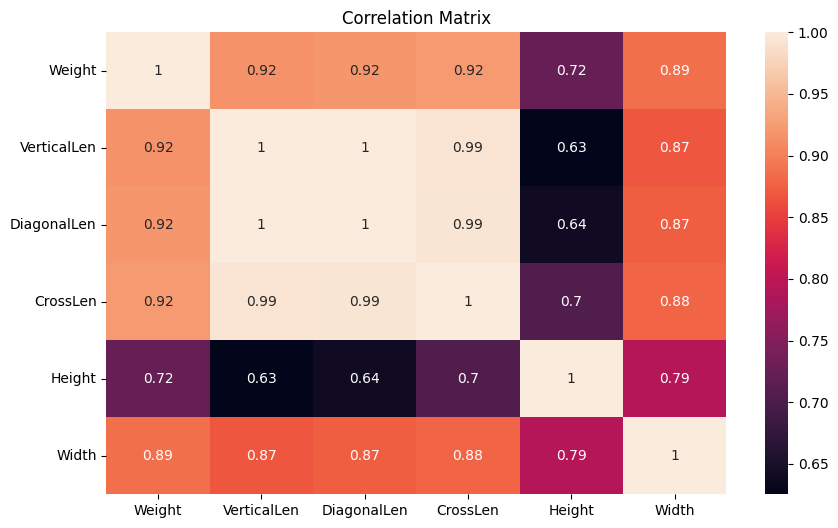

In [9]:
# y como parte de un análisis, revisaremos la correlación de las variables
df2 = df1.drop("Species", axis=1)
plt.rcParams["figure.figsize"] = (10,6)
sns.heatmap(df2.corr(), annot =True)
plt.title('Correlation Matrix')

Al analizar la correlación, vemos que las variables CrossLen, VerticalLen y DiagonalLen están altamente correlacionadas (su valor de correlación es cercano al 1) por lo que, conservar estas variables puede causar problemas, es decir, el dataset no tendría variables linealmente independientes, lo que es un requisito para crear modelos de regresión.


In [10]:
# eliminando variables no independientes
df3 = df1.drop(["DiagonalLen", "CrossLen"], axis=1)
df3.head()

,Species,Weight,VerticalLen,Height,Width
0,Bream,242.0,23.2,11.5200,4.0200
1,Bream,290.0,24.0,12.4800,4.3056
2,Bream,340.0,23.9,12.3778,4.6961
3,Bream,363.0,26.3,12.7300,4.4555
4,Bream,430.0,26.5,12.4440,5.1340


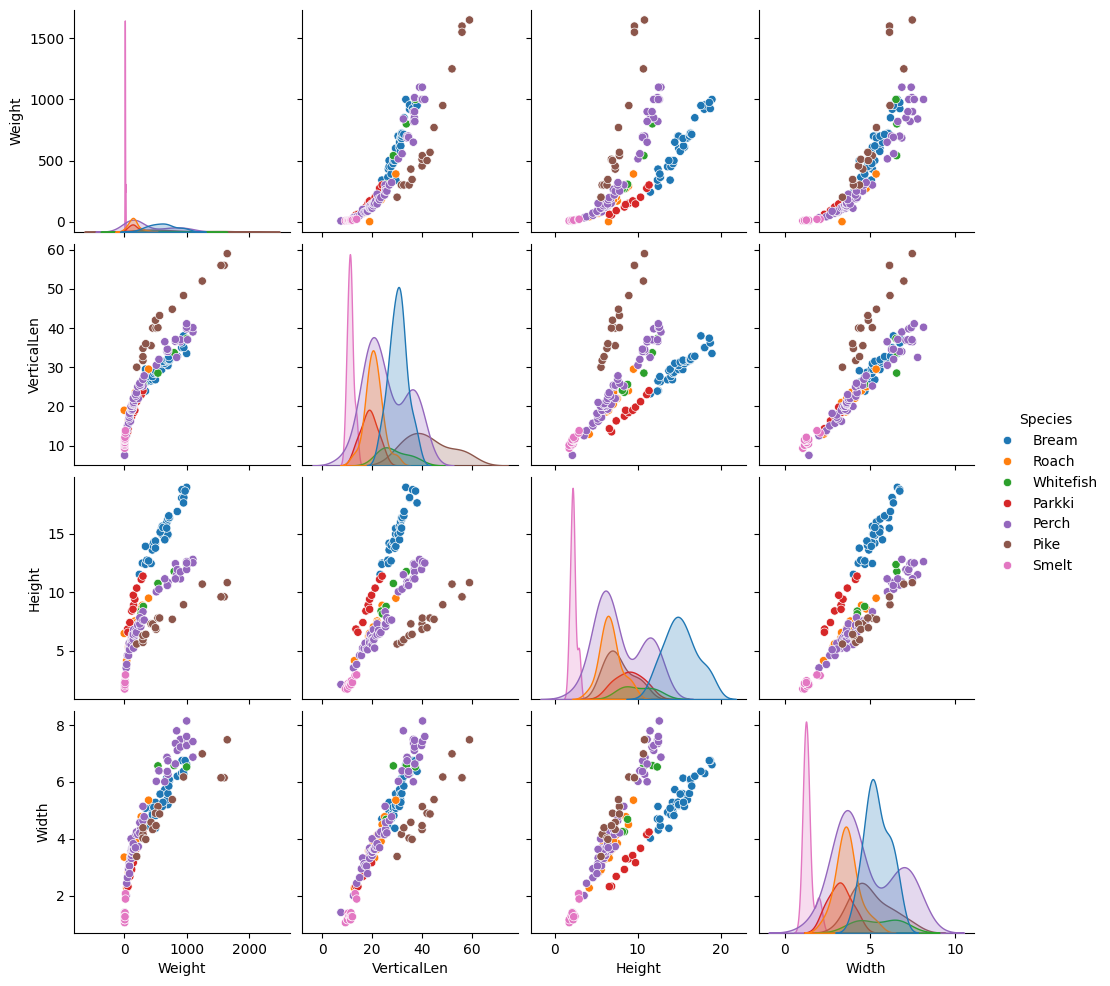

In [11]:
# visualizando los datos
sns.pairplot(df3, kind= "scatter", hue="Species")
# en el pairplot se puede apreciar que hay ciertas correlaciones entre ancho y alto. Sin embargo, entre diferentes especies hay variaciones.

In [22]:
# Preprocesando el conjunto de datos
df3.isna().sum() # revisando si hay nulos

Species        0
Weight         0
VerticalLen    0
Height         0
Width          0
dtype: int64

In [23]:
# Eliminando casos imposibles con la lógica del dataset. Por ejemplo, peces con peso o longitudes que sean cero
df3[df3["Weight"] == 0]
# se debe mostrar una tabla con los eliminados, eliminamos empleando el index

,Species,Weight,VerticalLen,Height,Width
40,Roach,0.0,19.0,6.4752,3.3516


In [24]:
df3.drop([40])

,Species,Weight,VerticalLen,Height,Width
0,Bream,242.0,23.2,11.5200,4.0200
1,Bream,290.0,24.0,12.4800,4.3056
2,Bream,340.0,23.9,12.3778,4.6961
3,Bream,363.0,26.3,12.7300,4.4555
4,Bream,430.0,26.5,12.4440,5.1340
...,...,...,...,...,...
154,Smelt,12.2,11.5,2.0904,1.3936
155,Smelt,13.4,11.7,2.4300,1.2690
156,Smelt,12.2,12.1,2.2770,1.2558
157,Smelt,19.7,13.2,2.8728,2.0672


In [25]:
# ya que las especies son un valor categórico, y necesitamos números para entrenar modelos, la mejor alternativa es realizar un "one-hot" encoding, que convierte los nombres de especies (7 especies) en un arreglo de 1x7 donde solo se verá un uno (True) en la columna que corresponda al nombre, en el otro caso se tendrán ceros (False).
especies_codificadas = pd.get_dummies(df3.Species)
especies_codificadas.head()

,Bream,Parkki,Perch,Pike,Roach,Smelt,Whitefish
0,True,False,False,False,False,False,False
1,True,False,False,False,False,False,False
2,True,False,False,False,False,False,False
3,True,False,False,False,False,False,False
4,True,False,False,False,False,False,False


In [26]:
# luego creamos un dataframe que contenga toda la información
df4 = pd.concat([df3, especies_codificadas], axis="columns")
df4.head()
# como ya tenemos los nombres codificados, podemos deshacernos de la columna con los nombres y tambien la columna Whitefish
# que no nos sirve para el ejercicio, a Whitefish lo eliminamos porque solo hay 6 muestras, que son insuficientes para el ejercicio de entrenamiento de un modelo.
df5 = df4.drop(["Species", "Whitefish"], axis="columns")
df5.head()

,Weight,VerticalLen,Height,Width,Bream,Parkki,Perch,Pike,Roach,Smelt
0,242.0,23.2,11.5200,4.0200,True,False,False,False,False,False
1,290.0,24.0,12.4800,4.3056,True,False,False,False,False,False
2,340.0,23.9,12.3778,4.6961,True,False,False,False,False,False
3,363.0,26.3,12.7300,4.4555,True,False,False,False,False,False
4,430.0,26.5,12.4440,5.1340,True,False,False,False,False,False


### Creando un modelo de regresión
Para entrenar el modelo, se requieren datos de entrenamiento y datos de validación. También es necesario separar el dataframe en dos variables que sirvan como datos ($X$) y etiquetas ($y$)

In [27]:
# X tendrá los datos de entrenamiento
X = df5[["Height", "Width", "VerticalLen", "Bream", "Parkki", "Pike", "Roach", "Smelt"]]
y = df5[["Weight"]]
# particionando
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
# validando los resultados
print("Tamaño de X_train=", X_train.shape)
print("Tamaño de X_test=", X_test.shape)
print("Tamaño de y_train=", y_train.shape)
print("Tamaño de y_test=", y_test.shape)

Tamaño de X_train= (127, 8)
Tamaño de X_test= (32, 8)
Tamaño de y_train= (127, 1)
Tamaño de y_test= (32, 1)


### EJEMPLOS DE REGRESIÓN POLINÓMICA:

- **Regresión polinómica (no lineal):**

Como se tienen diferentes especies de peces, la relacion entre características como peso, ancho y alto no es lineal. Por lo tanto, una recta no va a modelar apropiadamente el comportamiento del peso de los peces en función de sus características.
 Crearemos una función para visualizar datos usando un polinomio con varios grados.

Las funciones que permiten trazar varios grados de un polinomio en función de los datos son `np.polyfit()` que funciona mediante mínimos cuadrados para resovler una ecuación polinómica. Esta función requiere suministrar datos (x,y) y el grado del polinomio a ajustar. Polyfit retornará los coeficientes que mejor se ajusten a los datos.

In [28]:
def polynomial_plot(feature, label):
    # Crear un array de una dimensión para reducir el arreglo de dos dimensiones a una.
    x_coordinates = feature
    y_coordinates = np.squeeze(label)

    # polinomio de primer grado (recta)
    linear_func = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 1))
    # polinomio de segundo grado (curva parabólica)
    #quadratic_func = np.poly1d(np.polyfit(x_coordinates, y_coordinates, 2))

    # Generar valores para visualizar los datos
    values = np.linspace(x_coordinates.min(), x_coordinates.max(), len(x_coordinates))

    plt.scatter(x_coordinates,y_coordinates, color='blue')
    plt.plot(values, linear_func(values), color='cyan', linestyle='dashed', label='Modelo lineal')
    #plt.plot(values, quadratic_func(values), color='red', label='Polinomio cuadrático')
    plt.xlabel('Datos de test de %s '%(feature.name))
    plt.ylabel('Peso del pez')
    plt.rcParams["figure.figsize"] = (10,6) # Custom figure size in inches
    plt.legend()
    plt.title("Función lineal para la característica %s" % (feature.name))
    #plt.title("Comparacion de funciones lineales y cuadráticas para la característica %s" % (feature.name))
    plt.show()

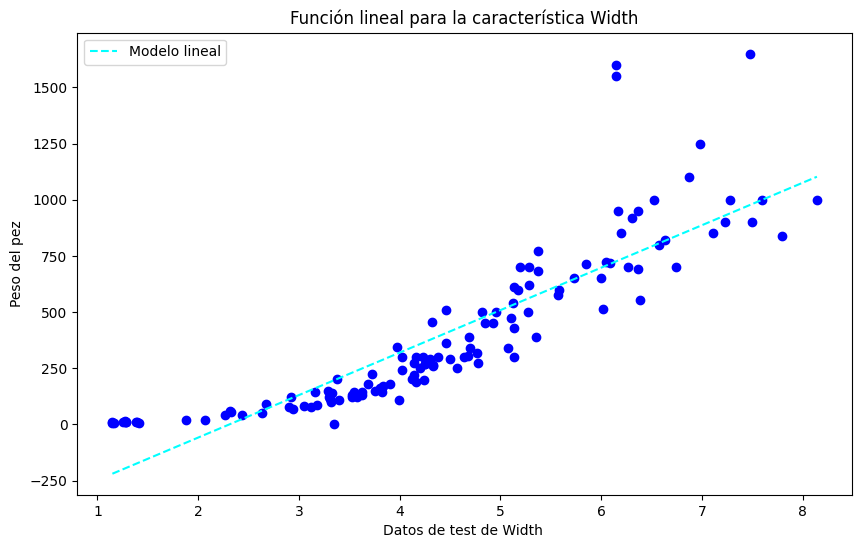

In [20]:
polynomial_plot(X_train.Width, y_train) # comparando modelos para el ancho y el peso del pez

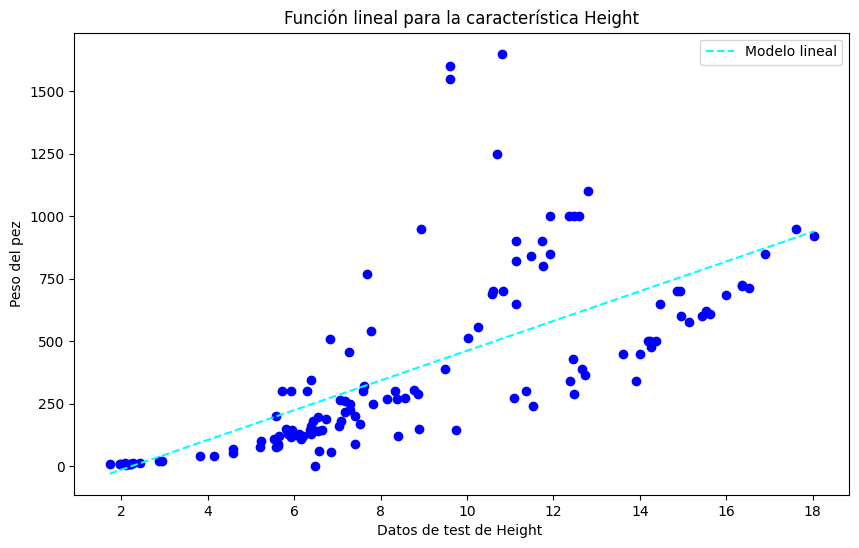

In [21]:
polynomial_plot(X_train.Height, y_train) # comparando modelos para el alto y el peso del pez

# TAREA en clase/casa:

1. Interpretar los resultados anteriores
2. De acuerdo a lo anterior, aplicar al mismo dataset (escogido por usted) los 2 métodos de regresión vistos hasta el momento (lineal simple, lineal múltiple).

- NOTA:

En la próxima sesión se continuara con la regresión polinómica para cualquier grando n>=1, y con la regresión logarítmica.